In [1]:
%matplotlib inline
# Imports
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread #
#from skimage import imshow
import os
#import shutil
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
import keras.backend.tensorflow_backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#from keras.applications.nasnet import NASNetMobile

from keras.applications.xception import Xception
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, Concatenate, GlobalMaxPooling2D
from keras.layers import Conv2D, BatchNormalization
import keras
from keras.models import Model 
#from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
#    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D \
#    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
#!pip install livelossplot
#from livelossplot import PlotLossesKeras
#import seaborn

Using TensorFlow backend.


In [2]:
TRAINING_LOGS_FILE = "training_logs.csv"
#MODEL_SUMMARY_FILE = "model_summary.txt"
#MODEL_FILE = "histopathologic_cancer_detector.h5"
#TRAINING_PLOT_FILE = "training.png"
#VALIDATION_PLOT_FILE = "validation.png"
#ROC_PLOT_FILE = "roc.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"
INPUT_DIR = './'
# Hyperparams
SAMPLE_COUNT = 85000
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 12
BATCH_SIZE = 64
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [3]:
data = pd.DataFrame({'PATH':glob('./train/*.tif')})

In [4]:
data['id'] = data.PATH.map(lambda x: x.split('/')[2][:-4])
data[:5]

,PATH,id
0,./train/a50ab94373e17680c2b0e7a52c080f5a7f40c0...,a50ab94373e17680c2b0e7a52c080f5a7f40c0ef
1,./train/5d5370630f56eeb4f8713d77d35f22549966b3...,5d5370630f56eeb4f8713d77d35f22549966b3f1
2,./train/642747e892925c87f5159aa66ed2d71c1316b9...,642747e892925c87f5159aa66ed2d71c1316b915
3,./train/1269281892fa9a53b4fd583e06bfaf6b5d2107...,1269281892fa9a53b4fd583e06bfaf6b5d21079b
4,./train/59c8c43c8a13ae5cbf6f28824b8660a5576a49...,59c8c43c8a13ae5cbf6f28824b8660a5576a49c0


In [5]:
train_labels = pd.read_csv('./train_labels.csv')

In [6]:
train_labels[:5]

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
print(train_labels.shape)
print(data.shape)

(220025, 2)
(220025, 2)


In [8]:
data = data.merge(train_labels,on='id')
data.columns = ['PATH','id', 'label']

In [9]:
data['id'].values[:5]

array(['a50ab94373e17680c2b0e7a52c080f5a7f40c0ef',
       '5d5370630f56eeb4f8713d77d35f22549966b3f1',
       '642747e892925c87f5159aa66ed2d71c1316b915',
       '1269281892fa9a53b4fd583e06bfaf6b5d21079b',
       '59c8c43c8a13ae5cbf6f28824b8660a5576a49c0'], dtype=object)

In [10]:
data.isna().any()

PATH     False
id       False
label    False
dtype: bool

In [11]:
def sample_images(nrow,ncol, file_list,sharp=False):
    assert len(file_list) == nrow*ncol, 'wrong length of file list'
    images = [imread(file) for file in file_list]
    
    #if np.var(images)!=0:
    #    images = images.clip(np.min(data),np.max(data))
    
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i],cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i],cmap="gray")
            #.reshape(IMG_SHAPE)
    plt.show()

In [12]:
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

Non cancer images


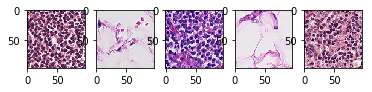

In [13]:
print('Non cancer images')
sample_images(1,5 ,data[data['label']==0]['PATH'][:5].values.tolist(), sharp=True)

Cancer images


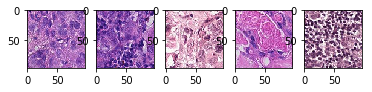

In [14]:
print('Cancer images')
sample_images(1,5 ,data[data['label']==1]['PATH'][:5].values.tolist(), sharp=True)

A close up of a cancer image
(96, 96, 3)


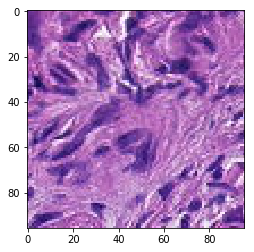

In [146]:
print('A close up of a cancer image')
num =9
print(imread(data[data['label']==1]['PATH'][num:num+1].values.tolist()[0]).shape)
plt.imshow(imread(data[data['label']==1]['PATH'][num:num+1].values.tolist()[0]))

In [16]:
print('To be able to validate which hyperparameters that work best for this problem ')
print('we will split the data up in a training and validation set')
training, validation = train_test_split(data, train_size=TRAINING_RATIO
, stratify=data['label'], random_state=42)

To be able to validate which hyperparameters that work best for this problem 
we will split the data up in a training and validation set


/home/hampus/anaconda3/envs/t-gpu/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [34]:
'We will use transfer learning with the xception architect'
def xception_3dl(image_size):
    inputs = Input(image_size)
    xception = Xception(include_top=False, input_tensor = inputs)(inputs)
    globmaxxcep = GlobalMaxPooling2D()(xception)
    globavgxcep = GlobalAveragePooling2D()(xception)
    flat = Flatten()(xception)
    concat = Concatenate(axis=-1)([globmaxxcep,globavgxcep,flat])
    concat = BatchNormalization()(concat)
    dense1 = Dense(128)(concat)
    dense1 = BatchNormalization()(dense1)
    dense2 = Dense(512)(dense1)
    dense2 = BatchNormalization()(dense2)
    dense3 = Dense(256)(dense2)
    dense3 = BatchNormalization()(dense3)
    
    
    out = Dense(1,activation='sigmoid')(dense3)
    model = Model(inputs=inputs, outputs=out)
    return model

In [35]:
xcept_3dl = xception_3dl((IMAGE_SIZE,IMAGE_SIZE,3))

In [36]:
xcept_3dl.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 3, 3, 2048)   20861480    input_4[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
flatten_4 

In [38]:
xcept_3dl.compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    #optimizer=keras.optimizers.adamax(lr=0.01))
    #optimizer= keras.optimizers.Adam(lr=0.01))
    #optimizer = keras.optimizers.rmsprop(0.01)
    #optimizer = keras.optimizers.SGD(0.01)
    optimizer = keras.optimizers.Adam(lr=0.0005))
                                      #, beta_1=0.9, beta_2=0.999))

In [17]:
training = training.reset_index()
validation = validation.reset_index()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#import tqdm
#import keras_utils
early_stopping = EarlyStopping(patience=20, verbose=1)#20
#from tqdm import tqdm_notebook, tnrange
#from itertools import chain
#model_checkpoint = ModelCheckpoint("./Incep.model", save_best_only=True, verbose=1)
model_checkpoint = ModelCheckpoint("./xcept_3dlbiga.h5", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1)#
#from keras_tqdm import TQDMNotebookCallback
from data_generators import Generator_from_listdir

batch_size = 64
generator_options = {'dim': (96,96),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,'bigaugment':True,
                   # 'crop':True,
                    # 'crop_dim':(32,32),
                     #'resize':True,
                     #'resize_dim':(96,96)
                    }
val_generator_options = {'dim': (96,96),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,'augment':False,
                        #'crop':True,
                     #'crop_dim':(32,32),
                     #'resize':True,
                     #'resize_dim':(96,96)
                        }
epochs = 100
#batch_size = 64
agenerator = Generator_from_listdir(training['PATH'].values.tolist(),
                                    training['id'].index.tolist(),
                                   training['label'].values.tolist(),**generator_options)
#train_generator(training, batch_size)
val_generator = Generator_from_listdir(validation['PATH'].values.tolist(),
                                      validation['id'].index.tolist(),
                                      validation['label'].values.tolist(),
                                       **val_generator_options)
#val_generator(validation,batch_size)
val_steps = validation.shape[0]//batch_size
stp_per_epoch = training.shape[0]//batch_size//10

history = xcept_3dl.fit_generator(generator=agenerator, steps_per_epoch = stp_per_epoch, nb_epoch  = epochs, 
                    verbose=1,# show_accuracy=True, 
                    validation_data=val_generator,
                   validation_steps = val_steps,
                   #(val_images, val_labels),
                    callbacks=[reduce_lr,model_checkpoint]
               #keras_utils.ModelSaveCallback(model_filename)],
                    , class_weight=None,
                     # use_multiprocessing=True,
                    #workers=3,
                    max_queue_size=7)
                    #workers=3, use_multiprocessing=True)


/home/hampus/anaconda3/envs/t-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/hampus/anaconda3/envs/t-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<data_gene..., steps_per_epoch=309, verbose=1, validation_data=<data_gene..., validation_steps=343, callbacks=[<keras.ca..., class_weight=None, max_queue_size=7, epochs=100)`


Epoch 1/100
309/309 [==============================] - 263s 852ms/step - loss: 0.3358 - acc: 0.8511 - val_loss: 0.2642 - val_acc: 0.8969

Epoch 00001: val_loss improved from inf to 0.26425, saving model to ./xcept_3dlbiga.h5
Epoch 2/100
309/309 [==============================] - 266s 861ms/step - loss: 0.3329 - acc: 0.8563 - val_loss: 0.2633 - val_acc: 0.8994

Epoch 00002: val_loss improved from 0.26425 to 0.26330, saving model to ./xcept_3dlbiga.h5
Epoch 3/100
309/309 [==============================] - 263s 851ms/step - loss: 0.3300 - acc: 0.8562 - val_loss: 0.2870 - val_acc: 0.8792

Epoch 00003: val_loss did not improve from 0.26330
Epoch 4/100
309/309 [==============================] - 260s 842ms/step - loss: 0.3262 - acc: 0.8588 - val_loss: 0.2308 - val_acc: 0.9125

Epoch 00004: val_loss improved from 0.26330 to 0.23084, saving model to ./xcept_3dlbiga.h5
Epoch 5/100
309/309 [==============================] - 254s 823ms/step - loss: 0.3200 - acc: 0.8607 - val_loss: 0.3194 - val_acc

Epoch 40/100
 81/309 [======>.......................] - ETA: 2:25 - loss: 0.2349 - acc: 0.9051

In [18]:
from keras.models import load_model
xcept_3dl = load_model('./xcept_3dlbiga.h5')

In [24]:
print(len(xcept_3dl.layers))
len(xcept_3dl.layers[1].layers)

14


132

In [36]:
xcept_3dl.layers[1].layers

In [37]:
# set all layers trainable by default
for layer in xcept_3dl.layers[1].layers:
    layer.trainable = True
    
# fix first layers in xception network(fine-tuning only last 62)
for layer in xcept_3dl.layers[1].layers[:-100]:
    layer.trainable = False

In [38]:
xcept_3dl.compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    #optimizer=keras.optimizers.adamax(lr=0.01))
    #optimizer= keras.optimizers.Adam(lr=0.01))
    #optimizer = keras.optimizers.rmsprop(0.01)
    #optimizer = keras.optimizers.SGD(0.01)
    optimizer = keras.optimizers.Adam(lr=0.0002))
                                      #, beta_1=0.9, beta_2=0.999))

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#import tqdm
#import keras_utils
early_stopping = EarlyStopping(patience=12, verbose=1)#20
#from tqdm import tqdm_notebook, tnrange
#from itertools import chain
#model_checkpoint = ModelCheckpoint("./Incep.model", save_best_only=True, verbose=1)
model_checkpoint = ModelCheckpoint("./xcept_3dlbiga.h5", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, min_lr=0.00001, verbose=1)#
#from keras_tqdm import TQDMNotebookCallback
from data_generators import Generator_from_listdir

batch_size = 64
generator_options = {'dim': (96,96),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,'bigaugment':True,
                   # 'crop':True,
                    # 'crop_dim':(32,32),
                     #'resize':True,
                     #'resize_dim':(96,96)
                    }
val_generator_options = {'dim': (96,96),
          'batch_size': batch_size,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,'augment':False,
                        #'crop':True,
                     #'crop_dim':(32,32),
                     #'resize':True,
                     #'resize_dim':(96,96)
                        }
epochs = 100
#batch_size = 64
agenerator = Generator_from_listdir(training['PATH'].values.tolist(),
                                    training['id'].index.tolist(),
                                   training['label'].values.tolist(),**generator_options)
#train_generator(training, batch_size)
val_generator = Generator_from_listdir(validation['PATH'].values.tolist(),
                                      validation['id'].index.tolist(),
                                      validation['label'].values.tolist(),
                                       **val_generator_options)
#val_generator(validation,batch_size)
val_steps = validation.shape[0]//batch_size
stp_per_epoch = training.shape[0]//batch_size//10

history = xcept_3dl.fit_generator(generator=agenerator, steps_per_epoch = stp_per_epoch, nb_epoch  = epochs, 
                    verbose=1,# show_accuracy=True, 
                    validation_data=val_generator,
                   validation_steps = val_steps,
                   #(val_images, val_labels),
                    callbacks=[reduce_lr,model_checkpoint]
               #keras_utils.ModelSaveCallback(model_filename)],
                    , class_weight=None,
                     # use_multiprocessing=True,
                    #workers=3,
                    max_queue_size=7)
                    #workers=3, use_multiprocessing=True)

/home/hampus/anaconda3/envs/t-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/hampus/anaconda3/envs/t-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<data_gene..., steps_per_epoch=309, verbose=1, validation_data=<data_gene..., validation_steps=343, callbacks=[<keras.ca..., class_weight=None, max_queue_size=7, epochs=100)`


Epoch 1/100
309/309 [==============================] - 266s 862ms/step - loss: 0.2427 - acc: 0.8993 - val_loss: 0.1195 - val_acc: 0.9580

Epoch 00001: val_loss improved from inf to 0.11954, saving model to ./xcept_3dlbiga.h5
Epoch 2/100
309/309 [==============================] - 263s 850ms/step - loss: 0.2538 - acc: 0.8956 - val_loss: 0.1203 - val_acc: 0.9587

Epoch 00002: val_loss did not improve from 0.11954
Epoch 3/100
309/309 [==============================] - 256s 830ms/step - loss: 0.2471 - acc: 0.8968 - val_loss: 0.1167 - val_acc: 0.9586

Epoch 00003: val_loss improved from 0.11954 to 0.11666, saving model to ./xcept_3dlbiga.h5
Epoch 4/100
309/309 [==============================] - 259s 839ms/step - loss: 0.2429 - acc: 0.8983 - val_loss: 0.1168 - val_acc: 0.9586

Epoch 00004: val_loss did not improve from 0.11666
Epoch 5/100
309/309 [==============================] - 261s 843ms/step - loss: 0.2502 - acc: 0.8934 - val_loss: 0.1187 - val_acc: 0.9584

Epoch 00005: val_loss did not 

/home/hampus/anaconda3/envs/t-gpu/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.394247). Check your callbacks.
  % delta_t_median)


 59/309 [====>.........................] - ETA: 2:41 - loss: 0.2141 - acc: 0.9126

In [19]:
batch_size=32
testdata = pd.DataFrame({'PATH':glob('./test/*.tif')})
testdata['id'] = testdata.PATH.map(lambda x: x.split('/')[2][:-4])

In [32]:
import importlib
import pred_w_gen
importlib.reload(pred_w_gen)
from pred_w_gen import pred_w_generator

In [21]:
ids,predictions2 = pred_w_generator(testdata.index.tolist(),
                                  testdata.PATH.values.tolist(),
                                   xcept_3dl, fliprotate = True)

first part done
2/6 done
3/6 done
4/6 done
5/6 done
6/6 done


In [22]:
answers = pd.DataFrame({'id':testdata.id.values.tolist(), 'label':predictions2})
answers.to_csv("xcept_3dlbiga_0.96calc.csv", index=False)

In [26]:
!kaggle competitions submit -f xcept_3dlbiga_0.96calc.csv -m 'hello' \
histopathologic-cancer-detection

100%|███████████████████████████████████████| 3.36M/3.36M [00:06<00:00, 580kB/s]
Successfully submitted to Histopathologic Cancer Detection

In [28]:
!kaggle competitions submissions histopathologic-cancer-detection

fileName                    date                 description                                         status    publicScore  privateScore  
--------------------------  -------------------  --------------------------------------------------  --------  -----------  ------------  
xcept_3dlbiga_0.96calc.csv  2019-01-18 10:03:24  hello                                               complete  0.9706       None          
xcepbiga_0.97calc.csv       2019-01-17 13:34:16  bigaugment no extra rounds calc                     complete  0.9669       None          
xcepbiga_0.97nocalc2.csv    2019-01-16 13:51:44  bigaugment no extra rounds2 no calculationslast ok  complete  0.9625       None          
xcepbiga_0.97nocalc.csv     2019-01-16 13:42:14  bigaugment no extra rounds2 no calculations         complete  0.9623       None          
xceptbiga_0.97.csv          2019-01-16 13:28:04  bigaugment no extra rounds2                         complete  0.5043       None          
xceptbiga_0.97.csv         

In [129]:
import importlib
import falsep_paths
importlib.reload(falsep_paths)


<module 'falsep_paths' from '/home/hampus/kaggle/histocancer/falsep_paths.py'>

In [130]:
from falsep_paths import false_pred_paths

In [ ]:

datapredictios = pred_w_generator(data.index.tolist(),
                                  data.PATH.values.tolist(),
                                   xcept_3dl, fliprotate = False)[1]

In [91]:
datapredictios[:5]

[0.999885082244873,
 0.997498095035553,
 0.0007762460154481232,
 0.00027943411259911954,
 0.00013378384755924344]

In [90]:
print(len(data['label'].values))
print(len(datapredictios))
print(len(data.PATH.values.tolist()))

220025
220025
220025


In [131]:
fp_paths,false_positives,fn_paths,false_negetives =false_pred_paths(data['label'].values.tolist(),datapredictios,data.PATH.values.tolist(),return_fn=True)

In [132]:
false_positives[-5:]

[0.9995824694633484,
 0.9997308850288391,
 0.9997531771659851,
 0.9998788833618164,
 0.999982476234436]

In [134]:
false_negetives[:5]

[8.520077244611457e-05,
 0.00013849265815224499,
 0.0001723544846754521,
 0.0002580723667051643,
 0.0002646816137712449]

The most false-positives


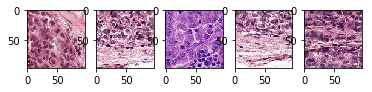

In [136]:
print('The most false-positives')
sample_images(1,5 ,fp_paths[-5:], sharp=True)

The most false-negatives


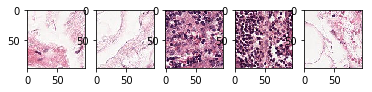

In [137]:
print('The most false-negatives')
sample_images(1,5,fn_paths[:5])